In [1]:
import os
import sys
from pathlib import Path
sys.path.insert(1, os.path.realpath(os.path.pardir))

import torch
import torch.nn.functional as F
from torch import nn
import safetensors
from accelerate import notebook_launcher

import einops
import gc 


from vector_quantize_pytorch import FSQ

import albumentations as A
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from simple_parsing import Serializable


from utils.data_utils import BrainDataset, get_tokenizer
from utils.train_utils import TrainConfig, run_train_model, count_parameters, load_model_weights
from utils.data_utils import process_file_v2

from models.vq_brain_per_channel import SoundStream, VAEConfig
# from transformers import GPT2Tokenizer
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')

model_config = VAEConfig(C=512, levels=(7, 5, 5, 5, 5), n_features=4, stride_list = (2, 2))
model = SoundStream(**model_config.to_dict())
model.train()
count_parameters(model)

x = torch.zeros(1, 32, 256 * 4)
loss, pred = model(x)

print(model_config, loss)


window_size = 256
n_electrodes = 256 * 4
max_tokens = 25

train_transform = A.Compose([
    
    # A.CoarseDropout(fill_value=0, p=0.5),
    # A.MultiplicativeNoise(multiplier=(0.9, 1.1), p=0.5),
    # A.GaussNoise(var_limit=0.005, mean=0, p=0.5),

    A.PadIfNeeded(min_height=window_size, min_width=n_electrodes, position='top_left', 
                  border_mode=0, value=0, always_apply=True),
    A.RandomCrop(height=window_size, width=n_electrodes, always_apply=True),
    # A.Crop(x_min=0, x_max=n_electrodes, y_min=0, y_max=window_size, always_apply=True),
])

test_transform = A.Compose([
    A.PadIfNeeded(min_height=window_size, min_width=n_electrodes, position='top_left', 
                  border_mode=0, value=0, always_apply=True),
    A.Crop(x_min=0, x_max=n_electrodes, y_min=0, y_max=window_size, always_apply=True),
])


data_path = Path("/drive/data/competitionData")

tokenize_function = None
process_file_function = process_file_v2

train_dataset = BrainDataset(data_path / 'train', 
                             process_file_function=process_file_function, 
                             tokenize_function=tokenize_function, 
                             transform=train_transform, 
                             max_tokens=max_tokens)

gc.collect()
test_dataset = BrainDataset(data_path / 'test', 
                            process_file_function=process_file_function, 
                            tokenize_function=tokenize_function, 
                            transform=test_transform, 
                            max_tokens=max_tokens)

gc.collect()

self.codebook_size 4375
self.downsample 4
Total: 35.71M, Trainable: 35.71M
VAEConfig(C=512, n_features=4, levels=(7, 5, 5, 5, 5), stride_list=(2, 2)) {'total_loss': tensor(0.0074, grad_fn=<MeanBackward0>), 'codebook_usage': 1.0}
Runed processing of the  /drive/data/competitionData/train


Processing files: 100%|██████████| 24/24 [01:51<00:00,  4.65s/file]


len of the dataset: 8800
max signal size: 906 | max tokens size: 87
median signal size: 297.0 | median tokens size: 31.0
Runed processing of the  /drive/data/competitionData/test


Processing files: 100%|██████████| 24/24 [00:10<00:00,  2.34file/s]


len of the dataset: 880
max signal size: 919 | max tokens size: 86
median signal size: 283.5 | median tokens size: 30.0


0

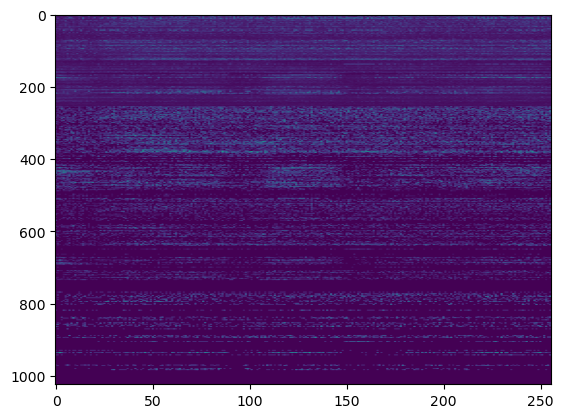

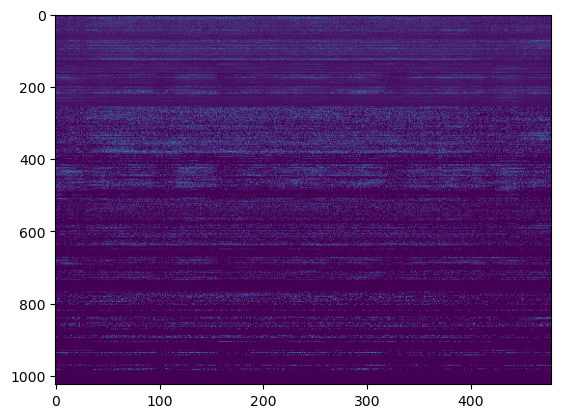

In [2]:
x = train_dataset[0][0]
x_real = train_dataset.inputs[0]

plt.imshow(x.T, aspect = 'auto')
plt.show()
plt.imshow(x_real.T, aspect = 'auto')

In [3]:
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
train_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

x, y, date = next(iter(train_dataloader))
# print(x.shape, y.shape, date.shape)
print('input text', y)

loss, logits = model(x, y, date)
loss
# plt.imshow(x.detach()[0].T)
# plt.show()

input text ('theocracy reconsidered',)


{'total_loss': tensor(0.0342, grad_fn=<MeanBackward0>), 'codebook_usage': 1.0}

In [4]:
project_name = 'vq_brain'
save_folder = Path("/drive/logs/kovalev")

train_config = TrainConfig(exp_name='4_features_35M_4x_4000_256_ws',
                           mixed_precision=True, 
                           batch_size=8,
                           grad_accum=2,
                           num_workers=3, 
                           pin_memory=True, 
                           eval_interval=1000, 
                           learning_rate=1e-4,
                           weight_decay=0, 
                           grad_clip=1000, 
                           lr_decay_iters=500_000, 
                           warmup_iters=2000, 
                           max_steps = 200_000, 
                           project_name=project_name, 
                           save_folder=save_folder
                          )

model = torch.compile(model)
args = (model, (train_dataset, test_dataset), train_config, model_config)
notebook_launcher(run_train_model, args, num_processes=1)

Launching training on one GPU.


/opt/conda/envs/pytorch/lib/python3.10/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(split_batches=True)
  warnings.warn(
wandb: Currently logged in as: koval_alvi. Use `wandb login --relogin` to force relogin


Device for training:  cuda
Num devices:  1
Completed initialization of scheduler
*******************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

AttributeError: 'float' object has no attribute 'item'

In [ ]:
from einops import rearrange

In [ ]:
weights = '/drive/logs/kovalev/vq_brain/4_features_17M_4x_4000_128_ws/step_5000_loss_0.0558.safetensors'
model  = load_model_weights(model, weights)
model.to('cuda')
model = model.eval()

In [ ]:
x = train_dataset[500][0]
print(x.shape)

In [ ]:
plt.imshow(x)
plt.colorbar()

In [ ]:
x_shaped  = rearrange(x, 't (r c) -> c t r', r=4)

In [ ]:
(x_shaped[0] == x[:, ::256]).mean()

In [ ]:
plt.imshow(x_shaped[0].T, aspect = 'auto')
plt.colorbar()

In [ ]:
x = test_dataset[500][0]
print(x.shape)
x = torch.from_numpy(x[None, :]).to('cuda')

# e = model.encoder(x)
indices = model.get_indices(x)
loss, y = model(x, return_preds=True)
print(y.shape)
print(loss)
print(F.l1_loss(y, x))
print(F.mse_loss(y, x))

x = x.detach().cpu()[0]
y = y.detach().cpu()[0]

import matplotlib.pyplot as plt
plt.plot(y[:, 220], label='recon')
# plt.show()
plt.plot(x[:, 220])
plt.legend()
plt.show()
plt.imshow(y[:, :].T, aspect='auto', vmin=-1, vmax=1)
plt.show()
plt.imshow(x[:, :].T, aspect='auto', vmin=-1, vmax=1)

In [ ]:
len(torch.unique(indices))

In [ ]:
quantized = quantized.detach().cpu()
indices = indices.detach().cpu()
print(quantized.shape)
plt.imshow(quantized[64].T)

plt.show()
plt.imshow(F.one_hot(indices[64].to(torch.long), 1000).T, aspect='auto')
plt.show()
plt.plot(indices[64])

In [ ]:
plt.imshow(quantized[0][:64].T.cpu().detach(), aspect='auto')

In [ ]:
plt.plot(indices[0].cpu())